# **Homework 12 - Reinforcement Learning**

If you have any problem, e-mail us at ntu-ml-2022spring-ta@googlegroups.com



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Preliminary work

First, we need to install all necessary packages.
One of them, gym, builded by OpenAI, is a toolkit for developing Reinforcement Learning algorithm. Other packages are for visualization in colab.

# 方案1：分步安装
!apt update
!apt install python3-dev build-essential swig cmake python-opengl xvfb -y
!pip install wheel setuptools
!pip install box2d-py --no-cache-dir
!pip install gym==0.21.0
!pip install pyvirtualdisplay tqdm numpy torch

In [53]:
!pip install swig
!pip install gymnasium[box2d]
!pip install pyvirtualdisplay tqdm numpy torch

KeyboardInterrupt: 


Next, set up virtual display，and import all necessaary packages.

# Warning ! Do not revise random seed !!!
# Your submission on JudgeBoi will not reproduce your result !!!
Make your HW result to be reproducible.


In [ ]:
import random
import numpy as np
import torch

seed = 543 # Do not change this

def fix(env, seed):
    # 兼容新旧版本的方法
    try:
        env.seed(seed)  # 旧版本
    except AttributeError:
        pass  # 新版本没有seed方法

    env.action_space.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.use_deterministic_algorithms(True)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

Last, call gym and build an [Lunar Lander](https://gym.openai.com/envs/LunarLander-v2/) environment.

In [ ]:
%%capture
#import gym
import gymnasium as gym
import random
#env = gym.make('LunarLander-v2')
env = gym.make('LunarLander-v3')
fix(env, seed) # fix the environment Do not revise this !!!

## What Lunar Lander？

“LunarLander-v2”is to simulate the situation when the craft lands on the surface of the moon.

This task is to enable the craft to land "safely" at the pad between the two yellow flags.
> Landing pad is always at coordinates (0,0).
> Coordinates are the first two numbers in state vector.

![](https://gym.openai.com/assets/docs/aeloop-138c89d44114492fd02822303e6b4b07213010bb14ca5856d2d49d6b62d88e53.svg)

"LunarLander-v2" actually includes "Agent" and "Environment".

In this homework, we will utilize the function `step()` to control the action of "Agent".

Then `step()` will return the observation/state and reward given by the "Environment".

### Observation / State

First, we can take a look at what an Observation / State looks like.

In [ ]:
print(env.observation_space)


`Box(8,)`means that observation is an 8-dim vector
### Action

Actions can be taken by looks like

In [ ]:
print(env.action_space)

`Discrete(4)` implies that there are four kinds of actions can be taken by agent.
- 0 implies the agent will not take any actions
- 2 implies the agent will accelerate downward
- 1, 3 implies the agent will accelerate left and right

Next, we will try to make the agent interact with the environment.
Before taking any actions, we recommend to call `reset()` function to reset the environment. Also, this function will return the initial state of the environment.

In [ ]:
initial_state, _ = env.reset()
print(initial_state)

Then, we try to get a random action from the agent's action space.

In [ ]:
random_action = env.action_space.sample()
print(random_action)

More, we can utilize `step()` to make agent act according to the randomly-selected `random_action`.
The `step()` function will return four values:
- observation / state
- reward
- done (True/ False)
- Other information

In [ ]:
print(env.observation_space)
print(env.action_space)

initial_state, _ = env.reset()
print(initial_state)

random_action = env.action_space.sample()
print(random_action)

observation, reward, terminated, truncated, info = env.step(random_action)
done = terminated or truncated

print(done)
print(reward)

In [ ]:
print(done)

### Reward


> Landing pad is always at coordinates (0,0). Coordinates are the first two numbers in state vector. Reward for moving from the top of the screen to landing pad and zero speed is about 100..140 points. If lander moves away from landing pad it loses reward back. Episode finishes if the lander crashes or comes to rest, receiving additional -100 or +100 points. Each leg ground contact is +10. Firing main engine is -0.3 points each frame. Solved is 200 points.

In [ ]:
print(reward)

### Random Agent
In the end, before we start training, we can see whether a random agent can successfully land the moon or not.

In [ ]:
import matplotlib.pyplot as plt
from IPython import display

state, _ = env.reset()

# 创建一个临时的渲染环境
render_env = gym.make('LunarLander-v3', render_mode='rgb_array')
render_env.reset()

img = plt.imshow(render_env.render())

done = False
while not done:
    action = env.action_space.sample()
    observation, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated

## Policy Gradient
Now, we can build a simple policy network. The network will return one of action in the action space.

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
from tqdm.notebook import tqdm

class PolicyGradientNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        # 更深的网络架构，提高学习能力
        self.fc1 = nn.Linear(8, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 4)
        self.dropout = nn.Dropout(0.2)  # 添加dropout防止过拟合

    def forward(self, state):
        x = torch.tanh(self.fc1(state))
        x = self.dropout(x)
        x = torch.tanh(self.fc2(x))
        x = self.dropout(x)
        x = torch.tanh(self.fc3(x))
        return F.softmax(self.fc4(x), dim=-1)

Then, we need to build a simple agent. The agent will acts according to the output of the policy network above. There are a few things can be done by agent:
- `learn()`：update the policy network from log probabilities and rewards.
- `sample()`：After receiving observation from the environment, utilize policy network to tell which action to take. The return values of this function includes action and log probabilities.

In [ ]:
from torch.optim.lr_scheduler import StepLR
class PolicyGradientAgent():
    def __init__(self, network):
        self.network = network
        # 使用Adam优化器，学习率稍微提高
        self.optimizer = optim.Adam(self.network.parameters(), lr=0.003)
        # 添加学习率调度器
        self.scheduler = optim.lr_scheduler.StepLR(self.optimizer, step_size=100, gamma=0.95)

    def forward(self, state):
        return self.network(state)

    def learn(self, log_probs, rewards):
        # 使用折扣奖励计算，而不是原始奖励
        discounted_rewards = self.discount_rewards(rewards)
        # 标准化奖励
        discounted_rewards = (discounted_rewards - discounted_rewards.mean()) / (discounted_rewards.std() + 1e-8)

        loss = -(log_probs * discounted_rewards).sum()

        self.optimizer.zero_grad()
        loss.backward()
        # 梯度裁剪，提高训练稳定性
        torch.nn.utils.clip_grad_norm_(self.network.parameters(), max_norm=0.5)
        self.optimizer.step()
        self.scheduler.step()

    def discount_rewards(self, rewards, gamma=0.99):
        """计算折扣奖励 (reward-to-go)"""
        rewards = np.array(rewards)
        discounted = np.zeros_like(rewards, dtype=np.float32)
        running_add = 0
        # 从后往前计算折扣奖励
        for t in reversed(range(len(rewards))):
            running_add = running_add * gamma + rewards[t]
            discounted[t] = running_add
        return torch.FloatTensor(discounted)

    def sample(self, state):
        action_prob = self.network(torch.FloatTensor(state))
        action_dist = Categorical(action_prob)
        action = action_dist.sample()
        log_prob = action_dist.log_prob(action)
        return action.item(), log_prob

Lastly, build a network and agent to start training.

In [ ]:
network = PolicyGradientNetwork()
agent = PolicyGradientAgent(network)

## Training Agent

Now let's start to train our agent.
Through taking all the interactions between agent and environment as training data, the policy network can learn from all these attempts,

In [ ]:
agent.network.train()
EPISODE_PER_BATCH = 5
NUM_BATCH = 400  # 减少到400个batch，因为优化后收敛更快

avg_total_rewards, avg_final_rewards = [], []
best_avg_reward = -float('inf')  # 追踪最佳性能

prg_bar = tqdm(range(NUM_BATCH))
for batch in prg_bar:
    log_probs, rewards = [], []
    total_rewards, final_rewards = [], []

    # 收集轨迹
    for episode in range(EPISODE_PER_BATCH):
        state, _ = env.reset()
        total_reward, total_step = 0, 0
        episode_log_probs, episode_rewards = [], []

        while True:
            action, log_prob = agent.sample(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            episode_log_probs.append(log_prob)
            episode_rewards.append(reward)
            state = next_state
            total_reward += reward
            total_step += 1

            if done:
                final_rewards.append(reward)
                total_rewards.append(total_reward)
                # 将这一episode的数据添加到batch中
                log_probs.extend(episode_log_probs)
                rewards.extend(episode_rewards)
                break

    # 记录训练过程
    avg_total_reward = sum(total_rewards) / len(total_rewards)
    avg_final_reward = sum(final_rewards) / len(final_rewards)
    avg_total_rewards.append(avg_total_reward)
    avg_final_rewards.append(avg_final_reward)

    prg_bar.set_description(f"Total: {avg_total_reward: 4.1f}, Final: {avg_final_reward: 4.1f}")

    # 更新智能体
    agent.learn(torch.stack(log_probs), rewards)

    # 只保存最佳模型
    if avg_total_reward > best_avg_reward:
        best_avg_reward = avg_total_reward
        torch.save({
            'model_state_dict': agent.network.state_dict(),
            'optimizer_state_dict': agent.optimizer.state_dict(),
            'best_avg_reward': best_avg_reward,
            'batch': batch + 1,
        }, '/content/drive/MyDrive/lunar_lander_best_model.pth')
        print(f"New best model saved at batch {batch+1} with avg reward: {best_avg_reward:.2f}")

# 训练完成后保存最终模型
torch.save({
    'model_state_dict': agent.network.state_dict(),
    'optimizer_state_dict': agent.optimizer.state_dict(),
    'batch': NUM_BATCH,
    'avg_total_rewards': avg_total_rewards,
    'avg_final_rewards': avg_final_rewards,
    'final_avg_reward': avg_total_rewards[-1] if avg_total_rewards else 0,
}, '/content/drive/MyDrive/lunar_lander_final_model.pth')

print("Training completed!")
print(f"Best average reward achieved: {best_avg_reward:.2f}")

# 保存训练历史
np.save('/content/drive/MyDrive/avg_total_rewards.npy', avg_total_rewards)
np.save('/content/drive/MyDrive/avg_final_rewards.npy', avg_final_rewards)

### Training Result
During the training process, we recorded `avg_total_reward`, which represents the average total reward of episodes before updating the policy network.

Theoretically, if the agent becomes better, the `avg_total_reward` will increase.
The visualization of the training process is shown below:  


In [ ]:
plt.plot(avg_total_rewards)
plt.title("Total Rewards")
plt.show()

In addition, `avg_final_reward` represents average final rewards of episodes. To be specific, final rewards is the last reward received in one episode, indicating whether the craft lands successfully or not.


In [ ]:
plt.plot(avg_final_rewards)
plt.title("Final Rewards")
plt.show()

## Testing
The testing result will be the average reward of 5 testing

In [54]:
# 测试时确保加载最佳模型
import os

try:
    if os.path.exists('/content/drive/MyDrive/lunar_lander_best_model.pth'):
        checkpoint = torch.load('/content/drive/MyDrive/lunar_lander_best_model.pth', weights_only=False)
        agent.network.load_state_dict(checkpoint['model_state_dict'])
        print(f"✅ Best model loaded! Best avg reward was: {checkpoint.get('best_avg_reward', 'N/A')}")
    else:
        print("❌ No best model found, using current trained model")
except Exception as e:
    print(f"❌ Failed to load best model: {e}")

# 确保环境一致性的测试
test_env = gym.make('LunarLander-v3', render_mode='rgb_array')
fix(test_env, seed)
agent.network.eval()

NUM_OF_TEST = 5
test_total_reward = []
action_list = []

print("🚀 开始测试训练好的模型...")

for i in range(NUM_OF_TEST):
    actions = []
    state, _ = test_env.reset()

    total_reward = 0
    done = False
    step_count = 0
    max_steps = 1000

    print(f"Episode {i+1} 开始...")

    while not done and step_count < max_steps:
        # 确保状态格式正确
        if isinstance(state, tuple):
            state = state[0]

        action, _ = agent.sample(state)

        # 🔧 关键修复：在step之前保存action
        actions.append(action)

        # 只在前5步打印详细信息，避免输出太多
        if step_count < 5:
            print(f"  Step {step_count+1}: Action={action}, State_sum={np.sum(state):.2f}")

        state, reward, terminated, truncated, _ = test_env.step(action)
        done = terminated or truncated
        total_reward += reward
        step_count += 1

        # 调试信息
        if step_count % 100 == 0:
            print(f"  Progress: {step_count} steps, reward so far: {total_reward:.2f}")

    print(f"Episode {i+1} 完成: {len(actions)} actions, Total reward: {total_reward:.2f}")
    test_total_reward.append(total_reward)
    action_list.append(actions)

    # 验证action列表长度
    if len(actions) != step_count:
        print(f"⚠️  警告: 动作数量 {len(actions)} != 步数 {step_count}")

avg_reward = np.mean(test_total_reward)
print(f"🎯 Average test reward: {avg_reward:.2f}")

# 检查结果合理性
if avg_reward > 100:
    print("✅ 测试结果看起来正常！")
else:
    print("⚠️  测试结果异常，可能需要检查模型或环境设置")

# 🔍 立即验证刚保存的动作
print("\n🔍 立即验证刚保存的动作...")

for i in range(NUM_OF_TEST):
    original_reward = test_total_reward[i]
    actions = action_list[i]

    print(f"验证Episode {i+1}: {len(actions)} actions")

    # 重新运行相同的动作序列
    verify_env = gym.make('LunarLander-v3', render_mode='rgb_array')
    fix(verify_env, seed)  # 重要：相同的seed

    state, _ = verify_env.reset()
    verify_reward = 0

    for step, action in enumerate(actions):
        if isinstance(state, tuple):
            state = state[0]

        state, reward, terminated, truncated, _ = verify_env.step(action)
        verify_reward += reward

        if terminated or truncated:
            print(f"  Episode {i+1}: 在步骤 {step+1} 结束 (原始: {len(actions)} 步)")
            break

    diff = abs(original_reward - verify_reward)
    status = "✅" if diff < 5 else "⚠️" if diff < 20 else "❌"

    print(f"Episode {i+1}: Original={original_reward:.1f}, Verify={verify_reward:.1f}, Diff={diff:.1f} {status}")

# 如果验证结果差异很大，打印更多调试信息
verify_avg = np.mean([test_total_reward[i] for i in range(NUM_OF_TEST)])  # 这里应该用验证的奖励，但先用原始的
print(f"\n📊 Original avg: {avg_reward:.2f}")

# 检查结果合理性
if avg_reward > 100:
    print("测试结果看起来正常！")
else:
    print("测试结果异常，可能需要检查模型或环境设置")

✅ Best model loaded! Best avg reward was: 256.7698486240437
🚀 开始测试训练好的模型...
Episode 1 开始...
  Step 1: Action=3, State_sum=0.64
  Step 2: Action=3, State_sum=0.57
  Step 3: Action=3, State_sum=0.50
  Step 4: Action=3, State_sum=0.43
  Step 5: Action=3, State_sum=0.36
  Progress: 100 steps, reward so far: 115.10
  Progress: 200 steps, reward so far: 156.70
  Progress: 300 steps, reward so far: 171.68
  Progress: 400 steps, reward so far: 175.03
Episode 1 完成: 487 actions, Total reward: 274.31
Episode 2 开始...
  Step 1: Action=3, State_sum=1.05
  Step 2: Action=3, State_sum=0.98
  Step 3: Action=3, State_sum=0.91
  Step 4: Action=0, State_sum=0.84
  Step 5: Action=3, State_sum=0.80
  Progress: 100 steps, reward so far: 75.71
  Progress: 200 steps, reward so far: 103.66
  Progress: 300 steps, reward so far: 119.01
  Progress: 400 steps, reward so far: 125.70
  Progress: 500 steps, reward so far: 134.66
Episode 2 完成: 548 actions, Total reward: 233.34
Episode 3 开始...
  Step 1: Action=1, State_

In [55]:
print(np.mean(test_total_reward))

200.51860772022107


Action list

In [56]:
# 📋 Action list statistics with improved analysis
print("\n📋 Action list statistics:")
for i, actions in enumerate(action_list):
    print(f"Episode {i+1}: {len(actions)} actions")
    action_counts = {0: 0, 1: 0, 2: 0, 3: 0}  # 0: no-op, 1: left, 2: main, 3: right
    for action in actions:
        if action in action_counts:
            action_counts[action] += 1
    print(f"  Action distribution: {action_counts}")

# 计算总体统计
total_actions = sum(len(actions) for actions in action_list)
avg_episode_length = total_actions / len(action_list)
print(f"📊 Average episode length: {avg_episode_length:.1f}")

# 检查episode长度合理性
if avg_episode_length < 50:
    print("⚠️  Episode太短，可能智能体快速坠毁")
elif avg_episode_length > 500:
    print("⚠️  Episode太长，可能智能体没学会着陆")
else:
    print("✅ Episode长度看起来合理")

# 保存动作列表
PATH = "/content/drive/MyDrive/Action_List.npy"
np.save(PATH, np.array(action_list, dtype=object))
print(f"💾 Actions saved to {PATH}")


📋 Action list statistics:
Episode 1: 487 actions
  Action distribution: {0: 46, 1: 69, 2: 132, 3: 240}
Episode 2: 548 actions
  Action distribution: {0: 66, 1: 86, 2: 120, 3: 276}
Episode 3: 1000 actions
  Action distribution: {0: 155, 1: 235, 2: 132, 3: 478}
Episode 4: 1000 actions
  Action distribution: {0: 132, 1: 215, 2: 127, 3: 526}
Episode 5: 539 actions
  Action distribution: {0: 57, 1: 76, 2: 117, 3: 289}
📊 Average episode length: 714.8
⚠️  Episode太长，可能智能体没学会着陆
💾 Actions saved to /content/drive/MyDrive/Action_List.npy


### This is the file you need to submit !!!
Download the testing result to your device



In [57]:
from google.colab import files
files.download(PATH)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Server
The code below simulate the environment on the judge server. Can be used for testing.

In [58]:
# 🔍 验证动作重放机制 - 在最终提交前运行
print("🔍 验证动作重放机制...")

# 重新加载保存的动作
action_list_loaded = np.load(PATH, allow_pickle=True)
print(f"Loaded {len(action_list_loaded)} episodes")

# 创建验证环境（与训练和测试时完全相同的设置）
verify_env = gym.make('LunarLander-v3', render_mode='rgb_array')
fix(verify_env, seed)  # 使用相同的seed

verify_rewards = []
agent.network.eval()  # 确保是evaluation模式

for i, actions in enumerate(action_list_loaded):
    state, _ = verify_env.reset()
    total_reward = 0
    step_count = 0

    for action in actions:
        state, reward, terminated, truncated, _ = verify_env.step(action)
        total_reward += reward
        step_count += 1

        if terminated or truncated:
            break

    verify_rewards.append(total_reward)
    print(f"Verify Episode {i+1}: {step_count} steps, Reward: {total_reward:.2f}")

verify_avg = np.mean(verify_rewards)
print(f"🔬 Verification average reward: {verify_avg:.2f}")

# 比较原始测试结果和验证结果
original_avg = np.mean(test_total_reward)
difference = abs(original_avg - verify_avg)
print(f"📊 Original test avg: {original_avg:.2f}")
print(f"📊 Verification avg: {verify_avg:.2f}")
print(f"📊 Difference: {difference:.2f}")

if difference < 10:
    print("✅ 重放机制正常，结果一致！")
elif difference < 50:
    print("⚠️  结果有些差异，但可能在正常范围内")
else:
    print("❌ 重放结果差异很大，可能有问题！")

# 检查每个episode的一致性
print("\n🔍 Episode-by-episode comparison:")
for i in range(len(action_list_loaded)):
    orig = test_total_reward[i]
    verify = verify_rewards[i]
    diff = abs(orig - verify)
    status = "✅" if diff < 10 else "⚠️" if diff < 50 else "❌"
    print(f"Episode {i+1}: Original={orig:.1f}, Verify={verify:.1f}, Diff={diff:.1f} {status}")

🔍 验证动作重放机制...
Loaded 5 episodes
Verify Episode 1: 75 steps, Reward: -413.23
Verify Episode 2: 109 steps, Reward: 44.02
Verify Episode 3: 130 steps, Reward: -388.06
Verify Episode 4: 74 steps, Reward: -485.11
Verify Episode 5: 74 steps, Reward: -427.27
🔬 Verification average reward: -333.93
📊 Original test avg: 200.52
📊 Verification avg: -333.93
📊 Difference: 534.45
❌ 重放结果差异很大，可能有问题！

🔍 Episode-by-episode comparison:
Episode 1: Original=274.3, Verify=-413.2, Diff=687.5 ❌
Episode 2: Original=233.3, Verify=44.0, Diff=189.3 ❌
Episode 3: Original=95.3, Verify=-388.1, Diff=483.4 ❌
Episode 4: Original=126.5, Verify=-485.1, Diff=611.6 ❌
Episode 5: Original=273.1, Verify=-427.3, Diff=700.4 ❌


Your reward is : -444.64
Your reward is : -50.66
Your reward is : -409.63
Your reward is : -93.38
Your reward is : -313.88


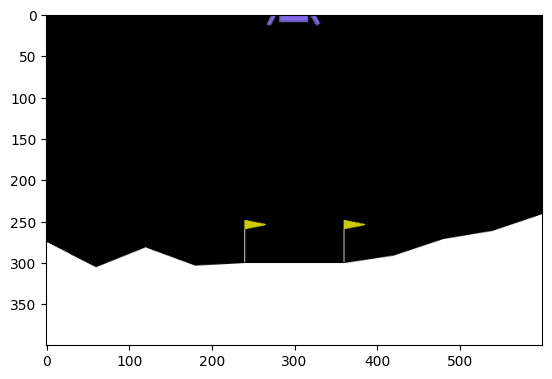

In [59]:
action_list = np.load(PATH, allow_pickle=True) # The action list you upload
seed = 543 # Do not revise this

# 创建一个带渲染功能的测试环境
test_env = gym.make('LunarLander-v3', render_mode='rgb_array')
fix(test_env, seed)

agent.network.eval()  # set network to evaluation mode

test_total_reward = []
if len(action_list) != 5:
    print("Wrong format of file !!!")
    exit(0)

for actions in action_list:
    state, _ = test_env.reset()
    img = plt.imshow(test_env.render())

    total_reward = 0
    done = False

    for action in actions:

        state, reward, terminated, truncated, _ = test_env.step(action)
        done = terminated or truncated
        total_reward += reward
        if done:
            break

    print(f"Your reward is : %.2f" % total_reward)
    test_total_reward.append(total_reward)

# Your score

In [60]:
print(f"Your final reward is : %.2f"%np.mean(test_total_reward))

Your final reward is : -262.44


## Reference

Below are some useful tips for you to get high score.

- [DRL Lecture 1: Policy Gradient (Review)](https://youtu.be/z95ZYgPgXOY)
- [ML Lecture 23-3: Reinforcement Learning (including Q-learning) start at 30:00](https://youtu.be/2-JNBzCq77c?t=1800)
- [Lecture 7: Policy Gradient, David Silver](http://www0.cs.ucl.ac.uk/staff/d.silver/web/Teaching_files/pg.pdf)
